
Processando coluna: cap-shape
Acurácia IterativeImputer+RF: 42.50%
Acurácia Moda Global:        44.00%

Processando coluna: cap-surface
Acurácia IterativeImputer+RF: 49.50%
Acurácia Moda Global:        40.00%

Processando coluna: bruises
Acurácia IterativeImputer+RF: 100.00%
Acurácia Moda Global:        53.00%

Processando coluna: odor
Acurácia IterativeImputer+RF: 87.00%
Acurácia Moda Global:        46.50%

Processando coluna: gill-color
Acurácia IterativeImputer+RF: 18.00%
Acurácia Moda Global:        26.50%


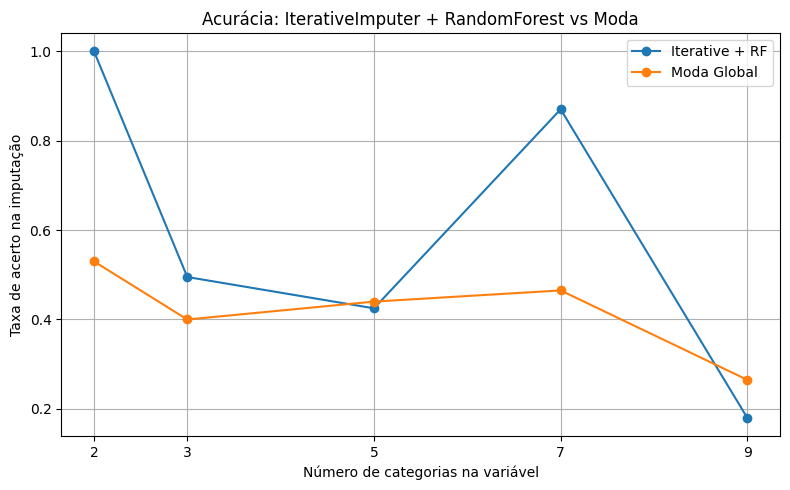

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

# 1. Carregar dados
file_path = 'mushrooms_data/agaricus-lepiota.data'
columns = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

df = pd.read_csv(file_path, header=None, names=columns)
df.replace('?', np.nan, inplace=True)
df_full = df.dropna().sample(n=1000, random_state=42).reset_index(drop=True)


# Variáveis a testar
test_cols = ['cap-shape', 'cap-surface', 'bruises', 'odor', 'gill-color']

missing_rate = 0.2
np.random.seed(42)

num_categories = []
accuracy_iterative = []
accuracy_mode = []

for col in test_cols:
    print(f"\nProcessando coluna: {col}")

    df_missing = df_full.copy()
    n_missing = int(len(df_missing) * missing_rate)
    missing_indices = np.random.choice(df_missing.index, size=n_missing, replace=False)
    df_missing.loc[missing_indices, col] = np.nan

    # Codificar todas as colunas como números inteiros usando OrdinalEncoder
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df_encoded = encoder.fit_transform(df_missing)

    # Imputar com IterativeImputer + RandomForestClassifier
    imputer = IterativeImputer(
        estimator=RandomForestClassifier(n_estimators=100, random_state=42),
        max_iter=10,
        random_state=42
    )
    df_imputed_array = imputer.fit_transform(df_encoded)

    # Inverter a codificação
    df_imputed = pd.DataFrame(df_imputed_array, columns=columns).round().astype(int)
    df_imputed = pd.DataFrame(encoder.inverse_transform(df_imputed), columns=columns)

    # Avaliar acurácia na coluna imputada
    true_values = df_full.loc[missing_indices, col].reset_index(drop=True)
    pred_values = df_imputed.loc[missing_indices, col].reset_index(drop=True)
    acc_iterative = (true_values == pred_values).mean()

    # Moda global
    global_mode = df_full[col].mode().iloc[0]
    df_imputed_mode = df_missing.copy()
    df_imputed_mode.loc[missing_indices, col] = global_mode
    acc_mode = (true_values.reset_index(drop=True) == df_imputed_mode.loc[missing_indices, col].reset_index(drop=True)).mean()


    num_categories.append(df_full[col].nunique())
    accuracy_iterative.append(acc_iterative)
    accuracy_mode.append(acc_mode)

    print(f"Acurácia IterativeImputer+RF: {acc_iterative:.2%}")
    print(f"Acurácia Moda Global:        {acc_mode:.2%}")

# Plotar
results = pd.DataFrame({
    'num_categories': num_categories,
    'accuracy_iterative': accuracy_iterative,
    'accuracy_mode': accuracy_mode
}).sort_values(by='num_categories')

plt.figure(figsize=(8, 5))
plt.plot(results['num_categories'], results['accuracy_iterative'], marker='o', label='Iterative + RF')
plt.plot(results['num_categories'], results['accuracy_mode'], marker='o', label='Moda Global')
plt.xticks(results['num_categories'])
plt.xlabel('Número de categorias na variável')
plt.ylabel('Taxa de acerto na imputação')
plt.title('Acurácia: IterativeImputer + RandomForest vs Moda')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

